# Web-scraping: сбор данных из баз данных и интернет-источников

*Алла Тамбовцева, НИУ ВШЭ*

## Семинар 3. Парсинг с библиотекой BeautifulSoup¶

В предыдущей серии (код с прошлого семинара):

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
page = requests.get("https://nplus1.ru/")
soup = BeautifulSoup(page.text)

raw_links = soup.find_all("a")
news = []

for link in raw_links:
    if "news" in link["href"]:
        news.append(link["href"])

links_full = []
for link in news:
    res = "https://nplus1.ru" + link
    links_full.append(res)

In [3]:
my_link = links_full[0]
my_page = requests.get(my_link)
my_soup = BeautifulSoup(my_page.text)

author = my_soup.find_all("meta", 
                 {"name" : "mediator_author"})[0].get("content")
date = my_soup.find_all("meta", 
                 {"itemprop" : "datePublished"})[0].get("content")
title = my_soup.find_all("title")[0].text
desc = my_soup.find_all("meta", 
                        {"name" : "description"})[0].get("content")

div = my_soup.find_all("div", {"class" : "tables"})[0]
time = div.find_all("span")[0].text
diffc = div.find_all("span", {"class" : "difficult-value"})[0].text
rubs_raw = div.find_all("p")[0].find_all("a")
rubs = []
for r in rubs_raw:
    rubs.append(r.text)
rubs_str = ", ".join(rubs)

С прошлого раза у нас осталась одна задача – выгрузить текст новости и очистить его от лишней информации. Попробуем выполнить поиск по тэгам! Текст у нас обычно записывается абзацами, а абзацы заключаются в тэг `<p></p>`:

In [4]:
my_soup.find_all("p") 

[<p class="table">
 <a data-rubric="medicine" href="/rubric/medicine">Медицина</a>
 <a data-theme="coronavirus-history" href="/theme/coronavirus-history">Коронавирусные хроники</a>
 </p>, <p class="table">
 <a href="/news/2022/02/17">
 <time content="2022-02-17" data-unix="1645092304" itemprop="datePublished">
 <span>13:05</span>
 <span>17 Фев. 2022</span>
 </time>
 </a>
 </p>, <p class="table">
 <a href="/difficult/3.1">
 <span>Сложность</span>
 <span class="difficult-value">3.1</span>
 </a>
 </p>, <p class="title"></p>, <p class="credits">NIH / flickr.com</p>, <p>Японские вирусологи выяснили, что подвариант омикрона BA.2 лучше размножается в легких и вызывает в них более тяжелые изменения, чем его предшественник. Когда ученые заразили хомячков как BA.1, так и BA.2, то оказалось, что вирусная нагрузка на периферии легких у животных, инфицированных BA.2, в девять раз выше. Препринт исследования <a href="https://www.biorxiv.org/content/10.1101/2022.02.14.480335v1.full.pdf" rel="nofollow

К сожалению, не только текст новости заключается в тэг `<p></p>`, в таких тэгах можно встретить другую информацию: дату, время, сообщение об авторских правах и даже код на JavaScript. Чтобы отфильтровать только нужную информацию, попробуем уточнить поиск. Но как? Заметим, что у тэгов `<p>`, в которые заключены абзацы с текстом новости, нет дополнительных атрибутов, в частности нет атрибута `class`. А у тэгов `<p>`, которые содержат что-то отличное от текста новости, такой атрибут есть. Значит, можно поступить по-хитрому – запросить только те тэги `<p>`, где `class` пустой!

In [5]:
# None – пустота, специальный «пустой» тип 
# похож на NA или NaN в анализе данных

my_soup.find_all("p", {"class" : None})  

[<p>Японские вирусологи выяснили, что подвариант омикрона BA.2 лучше размножается в легких и вызывает в них более тяжелые изменения, чем его предшественник. Когда ученые заразили хомячков как BA.1, так и BA.2, то оказалось, что вирусная нагрузка на периферии легких у животных, инфицированных BA.2, в девять раз выше. Препринт исследования <a href="https://www.biorxiv.org/content/10.1101/2022.02.14.480335v1.full.pdf" rel="nofollow" target="_blank">опубликован</a> на bioRxiv.</p>,
 <p>Подвариант омикрона BA.2, который в начале 2022 года стал распространяться быстрее своего предшественника, приобрел 28 дополнительных мутаций. По всей видимости, это и сделало его более заразным — датские медики <a href="https://nplus1.ru/news/2022/02/01/omicron-upgraded" target="_blank">выяснили</a>, что вероятность заболеть им при контакте с заразившимся родственником на 33 процента больше, чем при контакте с заразившимся первоначальным вариантом омикрона. Об остальных свойствах BA.2 было известно мало. Та

Сохраним результат в переменную:

In [6]:
pars_raw = my_soup.find_all("p", {"class" : None})

Извлечём текст из тэгов и сохраним абзацы в отдельный список:

In [7]:
pars_text = []
for p in pars_raw:
    pars_text.append(p.text)
pars_text

['Японские вирусологи выяснили, что подвариант омикрона BA.2 лучше размножается в\xa0легких и\xa0вызывает в\xa0них более тяжелые изменения, чем его предшественник. Когда ученые заразили хомячков как BA.1, так и\xa0BA.2, то\xa0оказалось, что вирусная нагрузка на\xa0периферии легких у\xa0животных, инфицированных BA.2, в\xa0девять раз выше. Препринт исследования опубликован на\xa0bioRxiv.',
 'Подвариант омикрона BA.2, который в\xa0начале 2022 года стал распространяться быстрее своего предшественника, приобрел 28\xa0дополнительных мутаций. По\xa0всей видимости, это и\xa0сделало его более заразным\xa0— датские медики выяснили, что вероятность заболеть им\xa0при контакте с\xa0заразившимся родственником на\xa033\xa0процента больше, чем при контакте с\xa0заразившимся первоначальным вариантом омикрона. Об\xa0остальных свойствах BA.2 было известно мало. Так Министерство Здравоохранения Дании, проанализировав предварительные данные о\xa0заболеваемости, сообщило, что пока нет причин предполагать, 

### Задача 1

Используя список `pars_text`, «склейте» из абзацев целый текст и сохраните его в переменную `text`.

In [9]:
# используем метод .join()
# склеиваем по пробелу, поэтому " " перед .join()

text = " ".join(pars_text)
text

'Японские вирусологи выяснили, что подвариант омикрона BA.2 лучше размножается в\xa0легких и\xa0вызывает в\xa0них более тяжелые изменения, чем его предшественник. Когда ученые заразили хомячков как BA.1, так и\xa0BA.2, то\xa0оказалось, что вирусная нагрузка на\xa0периферии легких у\xa0животных, инфицированных BA.2, в\xa0девять раз выше. Препринт исследования опубликован на\xa0bioRxiv. Подвариант омикрона BA.2, который в\xa0начале 2022 года стал распространяться быстрее своего предшественника, приобрел 28\xa0дополнительных мутаций. По\xa0всей видимости, это и\xa0сделало его более заразным\xa0— датские медики выяснили, что вероятность заболеть им\xa0при контакте с\xa0заразившимся родственником на\xa033\xa0процента больше, чем при контакте с\xa0заразившимся первоначальным вариантом омикрона. Об\xa0остальных свойствах BA.2 было известно мало. Так Министерство Здравоохранения Дании, проанализировав предварительные данные о\xa0заболеваемости, сообщило, что пока нет причин предполагать, что н

### Задача 2

Подумайте, каким образом из `text` можно убрать информацию, не относящуюся к тексту новости. Уберите её и сохраните изменения в переменной `text`.

In [12]:
# используем метод .split()
# он разбивает текст на часть до "Нашли опечатку?" и после
# и возвращает список из двух элементов
# потом берём из списка первый элемент (до) с индексом 0

text = text.split("Нашли опечатку?")[0] 

### Задача 3

Замените символ `\xa0` на пробел и сохраните изменения в переменной `text`. Подсказка: запросите `help(text.replace)`.

In [14]:
help(text.replace) 

Help on built-in function replace:

replace(old, new, count=-1, /) method of builtins.str instance
    Return a copy with all occurrences of substring old replaced by new.
    
      count
        Maximum number of occurrences to replace.
        -1 (the default value) means replace all occurrences.
    
    If the optional argument count is given, only the first count occurrences are
    replaced.



In [16]:
# на первом месте – что заменяем, на втором – на что
# \xa0 – неразрывный пробел

text = text.replace("\xa0", " ") 

### Задача 4

Напишите функцию `get_info()`, которая принимает на вход ссылку на новость, а возвращает список со всеми характеристиками, которые мы извлекли выше для тестовой новости.

In [17]:
# помещаем весь код, который мы написали для одной ссылки
# внутрь функции и следим за тем, чтобы название аргумента 
# (my_link) совпадало с названием переменной, с которой мы дальше
# работаем в самой функции

def get_info(my_link):
    my_page = requests.get(my_link)
    my_soup = BeautifulSoup(my_page.text)

    author = my_soup.find_all("meta", 
                     {"name" : "mediator_author"})[0].get("content")
    date = my_soup.find_all("meta", 
                     {"itemprop" : "datePublished"})[0].get("content")
    title = my_soup.find_all("title")[0].text
    desc = my_soup.find_all("meta", 
                            {"name" : "description"})[0].get("content")

    div = my_soup.find_all("div", {"class" : "tables"})[0]
    time = div.find_all("span")[0].text
    diffc = div.find_all("span", {"class" : "difficult-value"})[0].text
    rubs_raw = div.find_all("p")[0].find_all("a")
    rubs = []
    for r in rubs_raw:
        rubs.append(r.text)
    rubs_str = ", ".join(rubs)
    pars_raw = my_soup.find_all("p", {"class" : None})
    pars_text = []
    for p in pars_raw:
        pars_text.append(p.text)
    text = " ".join(pars_text)
    text = text.split("Нашли опечатку?")[0] 
    text = text.replace("\xa0", " ") 
    result = [title, desc, author, date, time, diffc, rubs_str, text] 
    return result

In [18]:
# проверяем на примере

get_info(links_full[5]) 

['Нейросеть DeepMind научилась удерживать плазму в токамаке',
 'Ее работу проверили на реальном токамаке в Швейцарии',
 'Григорий Копиев',
 '2022-02-16',
 '21:35',
 '6.2',
 'IT, Физика',
 'Исследователи из DeepMind вместе с коллегами из Швейцарии создали алгоритм машинного обучения для удержания плазмы в токамаке. Они обучили его на высокоточном симуляторе, а затем показали работоспособность подхода на реальном токамаке в Швейцарии. Статья опубликована в Nature. DeepMind — британская компания, специализирующаяся на развитии методов машинного обучения, купленная Google в 2014 году. Наибольшую известность она получила благодаря своим игровым алгоритмам, которые обыграли людей в го, шахматы и StarCraft II. Но исследователи из DeepMind также занимаются сложными прикладными задачами, пытаясь решить их с помощью методов машинного обучения. Так, в 2016 году они разработали алгоритм синтеза речи WaveNet, существенно повлиявший на развитие этого направления, а за последний год с небольшим разра

### Задача 5

Примените функцию `get_info()` ко всем элементам списка `links_full` и создайте список списков `info` (один список внутри `info` – характеристики одной новости).

In [19]:
# импортируем функцию sleep из модуля time,
# чтобы при выгрузке делать задержки и чтобы
# сайт не понял, что мы его автоматически грабим

from time import sleep

In [22]:
# запускаем цикл for по всем ссылкам в списке links_full:
# применяем к каждой ссылке функцию get_info()
# и записываем результат в список info
# после каждого обновления списка info 
# ждём 1.5 секунды и пишем сообщение, что
# ссылка обработана

info = [] 
for link in links_full:
    res = get_info(link)
    info.append(res) 
    sleep(1.5) 
    print(link + "... done!") 

https://nplus1.ru/news/2022/02/17/virus-ba2... done!
https://nplus1.ru/news/2022/02/17/first-otologic-surgery... done!
https://nplus1.ru/news/2022/02/17/toxotes-chatareus... done!
https://nplus1.ru/news/2022/02/17/microrna-football... done!
https://nplus1.ru/news/2022/02/16/lung-universal-donors... done!
https://nplus1.ru/news/2022/02/16/deepmind-tokamak... done!
https://nplus1.ru/news/2022/02/16/m-77-agn... done!
https://nplus1.ru/news/2022/02/16/millimetre-redshift... done!
https://nplus1.ru/news/2022/02/16/alloy-elinvar... done!
https://nplus1.ru/news/2022/02/16/echosar... done!
https://nplus1.ru/news/2022/02/16/gran-turismo-gt-sophy... done!
https://nplus1.ru/news/2022/02/16/chrome-os-flex... done!
https://nplus1.ru/news/2022/02/16/arithmetic-rule... done!
https://nplus1.ru/news/2022/02/16/glacial-archaeology... done!
https://nplus1.ru/news/2022/02/16/x59... done!
https://nplus1.ru/news/2022/02/16/hiv-umbilical-cord-blood... done!
https://nplus1.ru/news/2022/02/16/msfd1-metastasis.

In [23]:
# info –  список списков
# один список внутри info = инфо по одной новости

info

[['Омикрон BA.2 опередил предшественника по способности размножаться в легких',
  'Он также вызывает более тяжелое повреждение легочной ткани',
  'Анастасия Кузнецова–Фантони',
  '2022-02-17',
  '13:05',
  '3.1',
  'Медицина, Коронавирусные хроники',
  'Японские вирусологи выяснили, что подвариант омикрона BA.2 лучше размножается в легких и вызывает в них более тяжелые изменения, чем его предшественник. Когда ученые заразили хомячков как BA.1, так и BA.2, то оказалось, что вирусная нагрузка на периферии легких у животных, инфицированных BA.2, в девять раз выше. Препринт исследования опубликован на bioRxiv. Подвариант омикрона BA.2, который в начале 2022 года стал распространяться быстрее своего предшественника, приобрел 28 дополнительных мутаций. По всей видимости, это и сделало его более заразным — датские медики выяснили, что вероятность заболеть им при контакте с заразившимся родственником на 33 процента больше, чем при контакте с заразившимся первоначальным вариантом омикрона. Об о

Теперь превратим полученный список списков в датафрейм - так удобнее будет работать, причём не только в Python:

In [24]:
import pandas as pd

In [25]:
df = pd.DataFrame(info)

Добавим столбцам датафрейма понятные названия (по умолчанию добавляются просто целочисленные индексы):

In [27]:
df.columns = ["title", "desc", "author", "date", "time", 
             "diffc", "rubs", "text"] 

Проверим, столбцы каких типов хранятся в датафрейме (аналог функции `str()` в R):

In [29]:
# object = string = текст
# float = числа с плавающей точкой (дробные)
# int = целые числа

df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
title     29 non-null object
desc      29 non-null object
author    29 non-null object
date      29 non-null object
time      29 non-null object
diffc     29 non-null object
rubs      29 non-null object
text      29 non-null object
dtypes: object(8)
memory usage: 1.9+ KB


Столбец `diffc` содержит дробные числа, но мы пока сохраняли их в виде текста, поэтому тип этого столбца `object`, а не `float`, как должно быть. Исправим тип столбца с помощью метода `astype()`. 

In [33]:
# выбираем столбец, преобразуем,
# потом сохраняем с тем же названием

df["diffc"] = df["diffc"].astype(float) 

Экспортируем датафрейм в файл Excel:

In [35]:
df.to_excel("/Users/allat/Desktop/nplus1.xlsx")

Напоследок построим какой-нибудь график по имеющимся данным. Проще всего это будет сделать для столбца `diffc`, так как он числовой. Построим для него гистограмму и посмотрим на распределение оценок сложности новостей.

Напишем магическую строку, которая будет сообщать Jupyter Notebook, что графики должны отображаться прямо здесь, в файле `.ipynb`.

In [37]:
%matplotlib inline

Для построения гистограммы воспользуемся методом `.hist()`, в него можно вписать аргумент, отвечающий за цвет (названия цветов из R тоже подходят, плюс, цвета в формате [HEX](https://www.color-hex.com/) тоже)

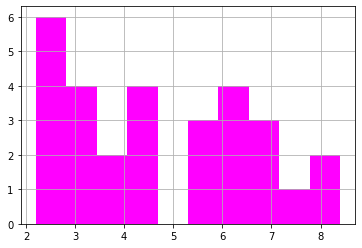

In [39]:
df["diffc"].hist(color = "magenta") 